# Description
Train optical neural network encoders using the images of the optically fanned out copies as the input to neural networks.

# Load libraries


In [1]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms

In [2]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch QuickDraw Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--epochs', type=int, default=5000, metavar='N',
                    help='number of epochs to train (default: 100)')
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(42)
if args.cuda:
    torch.cuda.manual_seed(42)

# Dataloaders

In [3]:
class GT_QuickDraw_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.data = torch.tensor(data_import, dtype = torch.float32)
        self.targets = torch.tensor(label_import, dtype = torch.long)
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.targets)
        
    def __getitem__(self, idx):
        data = self.data[idx]
        
        if self.transform:
             data = self.transform(self.data[idx].unsqueeze(0))
            
        return data, self.targets[idx]

In [18]:
""" Prepare data loaders """

data = np.load('./Quickdraw_GT_images_April_7.npz')

train_np = data['train_data']
train_labels = data['train_labels']

train_idx = []
val_idx = []
np.random.seed(42)
for l in np.unique(train_labels):
    class_idx = (train_labels == l).nonzero()[0]
    np.random.shuffle(class_idx)
    train_idx.append(class_idx[:250])
    val_idx.append(class_idx[250:])
train_idx = np.array(train_idx).flatten()
val_idx = np.array(val_idx).flatten()

val_np = train_np[val_idx,:,:]
train_np = train_np[train_idx,:,:]
val_labels = train_labels[val_idx]
train_labels = train_labels[train_idx]
test_np = data['test_data']
test_labels = data['test_labels']


transforms_input = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/190)])

transforms_input_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                         transforms.Lambda(lambda x: x.view(-1)), \
                                         transforms.Lambda(lambda x: x)])

#kwargs = {'num_workers': 20, 'pin_memory': True} if args.cuda else {}
kwargs = {}

""" input image loaders """
train_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_np, train_labels, transforms_input), \
    batch_size=args.batch_size, shuffle=True, **kwargs)

val_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_np, val_labels, transforms_input), \
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

test_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_np, test_labels, transforms_input), \
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [19]:
print(next(enumerate(train_loader_input))[1][0].shape)
print(next(enumerate(val_loader_input))[1][0].shape)
print(next(enumerate(test_loader_input))[1][0].shape)

torch.Size([128, 1600])
torch.Size([500, 1600])
torch.Size([505, 1600])


# NN Definitions

In [20]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out

def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [21]:
""" Definition of autoencoder structure """

coeffs = np.load('./Nonlinear_coeffs.npz')['coeffs']

class OpticalClassifier(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.nonlinear(x)
        x = self.fc2(x)
        y = self.digifc(x)
        return y

In [22]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[0.0]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and validation functions


In [23]:
def train(epoch, model, optimizer, criterion, train_loader0, norm0=1):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data/norm0)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
        if args.wandb:
            wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
#     accuracy = 100.0 * correct/len(train_loader0.dataset)
#     print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0, norm0=1):
    model.eval()
    test_loss = 0
    correct = 0
    hks = []
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data/norm0)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    val_stats = {"val_loss": test_loss, "accuracy": accuracy}
    for i, hk in enumerate(hks):
        val_stats[f"fc{i+1}"] = wandb.Histogram(hks[i].output.cpu())      
    
    if epoch%100 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    if args.wandb:
        wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [10]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [256, 512])
    lr_factor0 = 1E-2 * np.sqrt(128/100)
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/1.5, lr_factor0*1.5)
    learning_rate = lr_factor * np.sqrt(batch_size/128)
    swa_lr = trial.suggest_uniform("swa_lr", 1E-3, 1E-2)
    beta1 = trial.suggest_uniform("beta1", 0.999, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [1500, 2000])
    #warmup_epochs = trial.suggest_categorical("warmup_eps", [18, 24, 30])
    #model_description = f"Autoencoder_QAT_ar5wd5_lr_{learning_rate:.3f}_{lr_decay:.2f}" + f"_m_{momentum:.2f}" + f"_wp_{warmup_epochs}"+ f"_v_{trial.number}"
    model_description = f"AdamW_lr_{learning_rate:.6f}_bs_{batch_size}_lrf_{lr_factor:.4f}_b1_{beta1:.4f}_b2_{beta2:.4f}_swalr_{swa_lr:.3f}_{swa_start}" + f"_v_{trial.number}"
    
    # Instantiate a model for finetuning
    model = OpticalClassifier(36, 4)
    
    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
    if args.wandb:
        wandb.init(project=NAS_project_name, name=model_description, reinit=True)
        wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+1000)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager()
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 30:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:5]).mean().item() # return the average of top k accuracies to guide NAS

In [11]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, test_loader), n_trials=18)

In [12]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [0,]
rseeds = [1514,6,21,93258,2135]

NAS_project_name = "Quickdraw_nonlinear_digifc_retrain"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader_fc2, val_loader_fc2)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

KeyboardInterrupt: 

In [27]:
ray.shutdown()

# Check inputs

In [27]:
%matplotlib notebook

<IPython.core.display.Javascript object>


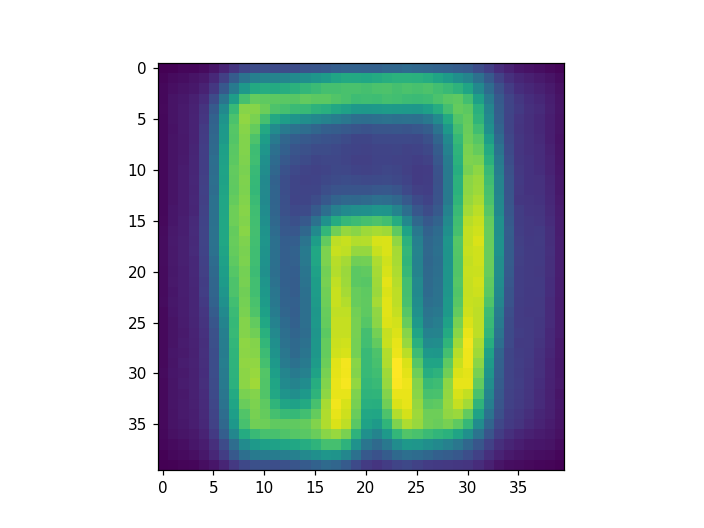

In [28]:
import matplotlib.pyplot as plt

idx = 60
fig, axes = plt.subplots(1,1)
plt.imshow(next(enumerate(train_loader_input))[1][0][0,:].view(40,-1))

In [ ]:
model = OpticalClassifier(36, 4)
args.wandb = False

if args.cuda:
    torch.cuda.set_device(0)
    model.cuda() # transfer the model from cpu to gpu

# Set up logging if necessary
if args.wandb:
    wandb.init(project=NAS_project_name, name=model_description, reinit=True)
    wandb.watch(model, log="all")

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1E-3, betas=(0.999, 0.999), weight_decay=0e-4)

# Loop around epoches
for epoch in range(1, args.epochs + 1):
    train(epoch, model, optimizer, criterion, train_loader_input)
    loss, accu = test(epoch, model, criterion, val_loader_input)


Test set: Epoch 100, Average loss: 1.1276, Accuracy: 314/500(63%)


Test set: Epoch 200, Average loss: 0.9231, Accuracy: 346/500(69%)


Test set: Epoch 300, Average loss: 0.8684, Accuracy: 358/500(72%)


Test set: Epoch 400, Average loss: 0.8258, Accuracy: 361/500(72%)


Test set: Epoch 500, Average loss: 0.7993, Accuracy: 371/500(74%)


Test set: Epoch 600, Average loss: 0.7828, Accuracy: 378/500(76%)


Test set: Epoch 700, Average loss: 0.7719, Accuracy: 378/500(76%)


Test set: Epoch 800, Average loss: 0.7612, Accuracy: 377/500(75%)


Test set: Epoch 900, Average loss: 0.7544, Accuracy: 380/500(76%)


Test set: Epoch 1000, Average loss: 0.7463, Accuracy: 380/500(76%)


Test set: Epoch 1100, Average loss: 0.7369, Accuracy: 379/500(76%)


Test set: Epoch 1200, Average loss: 0.7300, Accuracy: 381/500(76%)


Test set: Epoch 1300, Average loss: 0.7244, Accuracy: 378/500(76%)


Test set: Epoch 1400, Average loss: 0.7194, Accuracy: 378/500(76%)


Test set: Epoch 1500, Average loss: 0.7161

In [29]:
import matplotlib.pyplot as plt

model.cpu()
B = next(enumerate(test_loader_input))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(420) tensor(83.1683)


In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
